<a href="https://colab.research.google.com/github/VirtueZhao/Dive_into_Deep_Learning/blob/main/3_7_Concise_Implementation_of_Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import d2l
import torch
from torch import nn

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [5]:
loss = nn.CrossEntropyLoss()

In [6]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [22]:
from IPython import display

def accuracy(y_hat, y):
  # print("y_hat.shape: ", y_hat.shape)
  # print("y_hat.shape[1]: ", y_hat.shape[1])
  # print("y_hat: ", y_hat)

  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    # t_hat = y_hat.argmax(axis=0)
    # print("t_hat: ", t_hat)
    y_hat = y_hat.argmax(axis=1)
    # print("y_hat: ", y_hat)
  
  # print("y type: ",type(y))
  # print("y_hat type: ",type(y_hat))

  cmp = y_hat.type(y.dtype) == y
  # print("cmp: ",cmp)
  # print("cmp.type(y.dtype): ",cmp.type(y.dtype))
  # print("cmp.type(y.dtype).sum(): ",cmp.type(y.dtype).sum())

  return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval()
  metric = Accumulator(2)
  for X, y in data_iter:
    metric.add(accuracy(net(X), y), y.numel())
    # print("metric[0]: ", metric[0])
    # print("metric[1]: ", metric[1])
  return metric[0] / metric[1]

In [14]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
    # print("self.data: ", self.data)
  
  def add(self, *args):
    # print("self.data: ", self.data)
    # print("*args", args)
    # print("zip: ",list(zip(self.data, args)))
    self.data = [a + float(b) for a,b in zip(self.data, args)]
    # print("self.data: ", self.data)
    # print("-----")

  def reset(self):
    self.data = [0.0] * len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

In [12]:
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      updater.step()
      metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    else:
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
  
  return metric[0] / metric[2], metric[1] / metric[2]

In [10]:
class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, 
        ylim=None, xscale='linear', yscale='linear', fmts=('-','m--','g-.','r:'),
        nrows=1, ncols=1, figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes,]
    self.config_axes = lambda: d2l.set_axes(
        self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x,y,fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

In [8]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
              legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

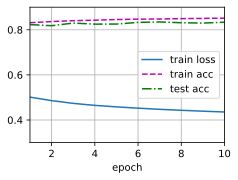

In [23]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)